In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [91]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [5]:
all_files = []
for root, dirs, files in os.walk("SKAB/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(f'{root}/{file}')

print("All files:")
all_files.sort()
display(all_files)

All files:


['SKAB/anomaly-free/anomaly-free.csv',
 'SKAB/other/11.csv',
 'SKAB/other/12.csv',
 'SKAB/other/13.csv',
 'SKAB/other/14.csv',
 'SKAB/other/15.csv',
 'SKAB/other/16.csv',
 'SKAB/other/17.csv',
 'SKAB/other/18.csv',
 'SKAB/other/19.csv',
 'SKAB/other/20.csv',
 'SKAB/other/21.csv',
 'SKAB/other/22.csv',
 'SKAB/other/23.csv',
 'SKAB/other/9.csv',
 'SKAB/valve1/0.csv',
 'SKAB/valve1/1.csv',
 'SKAB/valve1/10.csv',
 'SKAB/valve1/11.csv',
 'SKAB/valve1/12.csv',
 'SKAB/valve1/13.csv',
 'SKAB/valve1/14.csv',
 'SKAB/valve1/15.csv',
 'SKAB/valve1/2.csv',
 'SKAB/valve1/3.csv',
 'SKAB/valve1/4.csv',
 'SKAB/valve1/5.csv',
 'SKAB/valve1/6.csv',
 'SKAB/valve1/7.csv',
 'SKAB/valve1/8.csv',
 'SKAB/valve1/9.csv',
 'SKAB/valve2/0.csv',
 'SKAB/valve2/1.csv',
 'SKAB/valve2/2.csv',
 'SKAB/valve2/3.csv']

About this directory

The directory contains datasets from the benchmark. The structure of the directory is the following:
```
  └── data                        # Data files
      ├── anomaly-free         
      │   └── anomaly-free.csv     # Data obtained from the experiments with normal mode
      ├── valve1                  # Data obtained from the experiments with closing the valve at the outlet of the flow from the pump.
      │   ├── 1.csv            
      │   ├── 2.csv            
      │   ├── 3.csv            
      │   └── 4.csv                
      ├── valve2                  # Data obtained from the experiments with closing the valve at the flow inlet to the pump.
      │   ├── 1.csv            
      │   ├── 2.csv            
      │   ├── 3.csv            
      │   ├── 4.csv            
      │   ├── 5.csv            
      │   ├── 6.csv            
      │   ├── 7.csv            
      │   ├── 8.csv            
      │   ├── 9.csv            
      │   ├── 10.csv           
      │   ├── 11.csv           
      │   ├── 12.csv           
      │   ├── 12.csv           
      │   ├── 13.csv           
      │   ├── 14.csv           
      │   ├── 15.csv           
      │   └── 16.csv           
      └── other                   # Data obtained from the other experiments          
          ├── 13.csv              # Sharply behavior of rotor imbalance
          ├── 14.csv              # Linear behavior of rotor imbalance
          ├── 15.csv              # Step behavior of rotor imbalance
          ├── 16.csv              # Dirac delta function behavior of rotor imbalance
          ├── 17.csv              # Exponential behavior of rotor imbalance
          ├── 18.csv              # The slow increase in the amount of water in the circuit
          ├── 19.csv              # The sudden increase in the amount of water in the circuit
          ├── 20.csv              # Draining water from the tank until cavitation
          ├── 21.csv              # Two-phase flow supply to the pump inlet (cavitation)
          └── 22.csv              # Water supply of increased temperature
```

In [7]:
anomaly_free_data = pd.read_csv('SKAB/anomaly-free/anomaly-free.csv',
                                sep=';', index_col='datetime', parse_dates=True)
valve1_data = [pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file
               in all_files if 'valve1' in file]
valve2_data = [pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file
               in all_files if 'valve2' in file]
other_data = [pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file 
              in all_files if 'other' in file]

In [12]:
print("Anomaly free data")
display(anomaly_free_data.head())

print("Valve 1 anomaly")
display(valve1_data[0].head())

print("Valve 2 anomaly")
display(valve2_data[0].head())

print("Other data")
display(other_data[0].head())

Anomaly free data


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-02-08 13:30:47,0.206030,0.277924,1.81019,0.382638,90.1740,26.7760,228.208,121.664
2020-02-08 13:30:48,0.204366,0.275727,2.66317,-0.273216,90.2836,26.7760,227.245,122.000
2020-02-08 13:30:49,0.206103,0.278526,2.63758,0.382638,89.8666,26.7821,237.872,122.000
2020-02-08 13:30:51,0.204775,0.276948,2.32851,0.382638,90.2192,26.7773,230.422,121.338
2020-02-08 13:30:52,0.206052,0.278141,2.53422,0.382638,90.1449,26.7773,219.454,121.664


Valve 1 anomaly


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040452,1.35399,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0


Valve 2 anomaly


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 15:56:30,0.027608,0.039203,1.290480,0.054711,68.6194,24.3670,241.062,32.0362,0.0,0.0
2020-03-09 15:56:31,0.027166,0.039940,1.285650,0.382638,68.5923,24.3660,238.709,32.9649,0.0,0.0
2020-03-09 15:56:32,0.027718,0.040167,1.155880,0.054711,68.5207,24.3666,226.485,32.0362,0.0,0.0
2020-03-09 15:56:33,0.028045,0.038026,0.971268,0.382638,68.5425,24.3634,220.378,32.9649,0.0,0.0
2020-03-09 15:56:34,0.027644,0.038580,1.072460,-0.273216,68.6569,24.3639,233.922,32.0000,0.0,0.0


Other data


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 16:28:16,0.080968,0.132892,2.078540,0.054711,88.8333,22.0874,248.524,75.0000,0.0,0.0
2020-03-01 16:28:17,0.080721,0.137438,0.983799,0.710565,88.9111,22.0892,226.593,75.9813,0.0,0.0
2020-03-01 16:28:18,0.081400,0.128858,1.666630,0.054711,88.8676,22.0930,216.814,75.0000,0.0,0.0
2020-03-01 16:28:19,0.080755,0.135728,1.090530,0.382638,88.8907,22.0862,230.363,75.0189,0.0,0.0
2020-03-01 16:28:20,0.080394,0.132174,1.199950,0.382638,88.9437,22.0903,251.789,75.9813,0.0,0.0


In [21]:
print('Anomaly free data:', anomaly_free_data.index.min(), '/', anomaly_free_data.index.max(), '=== Length', len(anomaly_free_data))

for i, df in enumerate(valve1_data):
    print(f'Valve 1_{i}:', df.index.min(), '/', df.index.max(), '=== Length', len(df), '=== Anomaly:', len(df.query('anomaly == 1')))
    
for i, df in enumerate(valve2_data):
    print(f'Valve 2_{i}:', df.index.min(), '/', df.index.max(), '=== Length', len(df), '=== Anomaly:', len(df.query('anomaly == 1')))

for i, df in enumerate(other_data):
    print(f'Other {i}:', df.index.min(), '/', df.index.max(), '=== Length', len(df), '=== Anomaly:', len(df.query('anomaly == 1')))

Anomaly free data: 2020-02-08 13:30:47 / 2020-02-08 16:16:47 === Length 9401
Valve 1_0: 2020-03-09 10:14:33 / 2020-03-09 10:34:32 === Length 1148 === Anomaly: 401
Valve 1_1: 2020-03-09 10:34:33 / 2020-03-09 10:54:33 === Length 1145 === Anomaly: 402
Valve 1_2: 2020-03-09 13:34:39 / 2020-03-09 13:54:38 === Length 1146 === Anomaly: 401
Valve 1_3: 2020-03-09 13:54:39 / 2020-03-09 14:14:39 === Length 1141 === Anomaly: 399
Valve 1_4: 2020-03-09 14:14:40 / 2020-03-09 14:34:40 === Length 1140 === Anomaly: 399
Valve 1_5: 2020-03-09 14:34:41 / 2020-03-09 14:54:40 === Length 1140 === Anomaly: 399
Valve 1_6: 2020-03-09 14:54:41 / 2020-03-09 15:14:40 === Length 1139 === Anomaly: 399
Valve 1_7: 2020-03-09 15:14:41 / 2020-03-09 15:34:41 === Length 1150 === Anomaly: 404
Valve 1_8: 2020-03-09 10:54:34 / 2020-03-09 11:14:33 === Length 1075 === Anomaly: 337
Valve 1_9: 2020-03-09 11:14:34 / 2020-03-09 11:34:35 === Length 1149 === Anomaly: 404
Valve 1_10: 2020-03-09 11:34:36 / 2020-03-09 11:54:35 === Lengt

In [95]:
all_valve1 = pd.concat(valve1_data, axis=0)
all_valve1.sort_index(inplace=True)
display(all_valve1.head())
display(all_valve1.info())

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040452,1.35399,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18162 entries, 2020-03-09 10:14:33 to 2020-03-09 15:34:41
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Accelerometer1RMS    18162 non-null  float64
 1   Accelerometer2RMS    18162 non-null  float64
 2   Current              18162 non-null  float64
 3   Pressure             18162 non-null  float64
 4   Temperature          18162 non-null  float64
 5   Thermocouple         18162 non-null  float64
 6   Voltage              18162 non-null  float64
 7   Volume Flow RateRMS  18162 non-null  float64
 8   anomaly              18162 non-null  float64
 9   changepoint          18162 non-null  float64
dtypes: float64(10)
memory usage: 1.5 MB


None

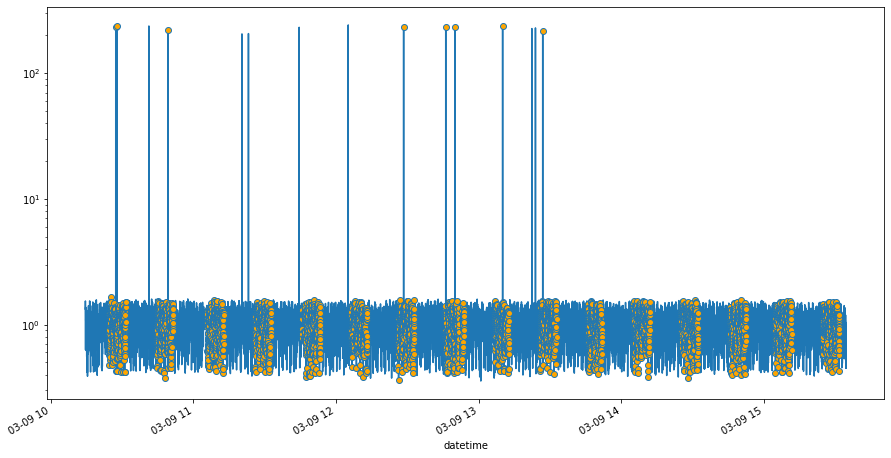

In [61]:
anomalies_index = [all_valve1.index.get_loc(date) for date in all_valve1.query('anomaly == 1').index]
all_valve1.Current.plot(
    markevery=anomalies_index, 
    marker='o',
    markerfacecolor='orange',
    logy=True
)
plt.show()

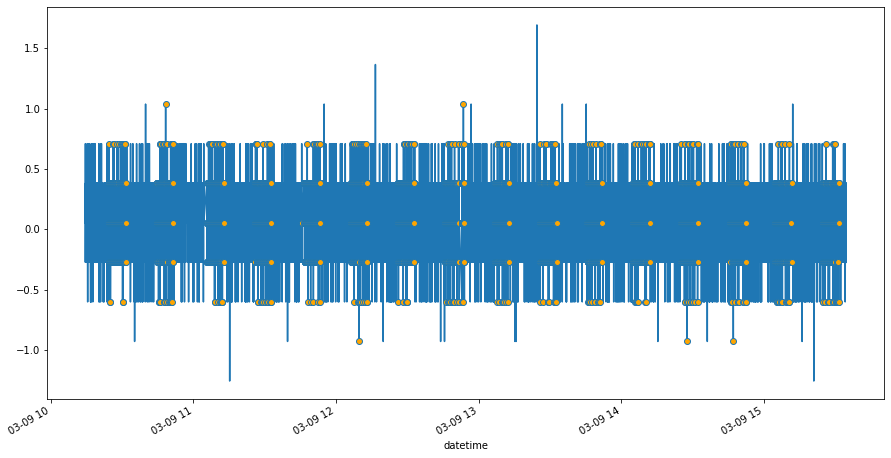

In [64]:
anomalies_index = [all_valve1.index.get_loc(date) for date in all_valve1.query('anomaly == 1').index]
all_valve1.Pressure.plot(
    markevery=anomalies_index, 
    marker='o',
    markerfacecolor='orange',
    logy=False
)
plt.show()

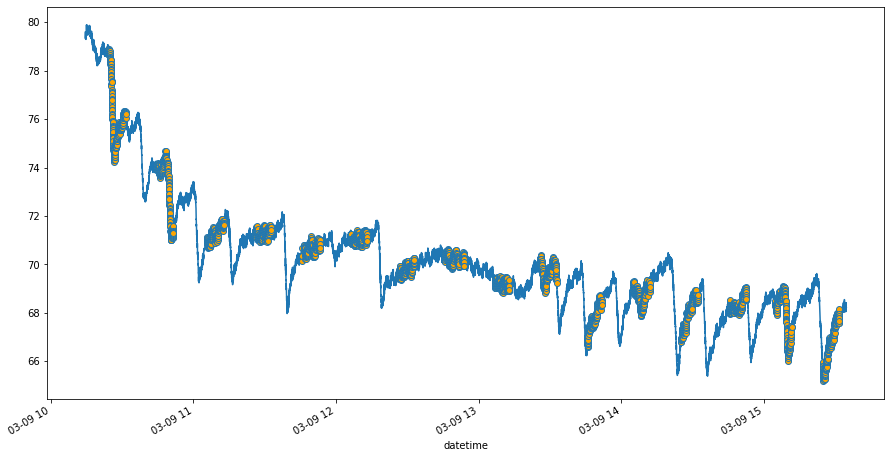

In [66]:
anomalies_index = [all_valve1.index.get_loc(date) for date in all_valve1.query('anomaly == 1').index]
all_valve1.Temperature.plot(
    markevery=anomalies_index, 
    marker='o',
    markerfacecolor='orange',
    logy=False
)
plt.show()

In [72]:
x = all_valve1.asfreq('S')
print(x[x.isnull().any(axis=1)].shape)
print(x.shape)
print(all_valve1.shape)

(1047, 10)
(19209, 10)
(18162, 10)


In [76]:
x[x.isnull().any(axis=1)].index

DatetimeIndex(['2020-03-09 10:14:51', '2020-03-09 10:15:14',
               '2020-03-09 10:15:36', '2020-03-09 10:16:01',
               '2020-03-09 10:16:28', '2020-03-09 10:16:50',
               '2020-03-09 10:17:11', '2020-03-09 10:17:24',
               '2020-03-09 10:17:47', '2020-03-09 10:18:09',
               ...
               '2020-03-09 15:30:57', '2020-03-09 15:31:22',
               '2020-03-09 15:31:46', '2020-03-09 15:32:09',
               '2020-03-09 15:32:35', '2020-03-09 15:33:00',
               '2020-03-09 15:33:20', '2020-03-09 15:33:41',
               '2020-03-09 15:34:07', '2020-03-09 15:34:32'],
              dtype='datetime64[ns]', name='datetime', length=1047, freq=None)

In [80]:
all_valve1.anomaly.value_counts()

0.0    11853
1.0     6309
Name: anomaly, dtype: int64

In [86]:
print(all_valve1.columns)
FEATURES = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']
TARGET = ['anomaly']

Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object')


In [96]:
from sklearn.utils import shuffle
from torch.utils.data import random_split

num_epochs = 10
batch_size = 64

data_valve_1 = all_valve1.asfreq('S', method='ffill')
train_size = int(0.8 * data_valve_1.shape[0])
test_size = data_valve_1.shape[0] - train_size

class Valve1DataSet(Dataset):
    def __init__(self, transform=None) -> None:
        super().__init__()
        self.n_samples = data_valve_1.shape[0]
        self.x_data = torch.from_numpy(data_valve_1[FEATURES].to_numpy())
        self.y_data = torch.from_numpy(data_valve_1[TARGET].to_numpy())

        self.transform = None
    
    def __getitem__(self, index) -> torch.Tensor:
        sample = self.x_data[index], self.y_data[index]
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self) -> int:
        return self.n_samples

full_valve1_dataset = Valve1DataSet()
train_valve1_dataset, test_valve1_dataset = random_split(full_valve1_dataset, [train_size, test_size])

train_valve1_loader = DataLoader(train_valve1_dataset, batch_size=batch_size, shuffle=True)
test_valve1_loader = DataLoader(test_valve1_dataset, batch_size=batch_size, shuffle=False)

In [111]:
min_length = len(valve1_data[0])
for data in valve1_data:
    if len(data) < min_length:
        min_length = len(data)
print("Max length available between all data Valve 1:", min_length)

Max length available between all data Valve 1: 1075


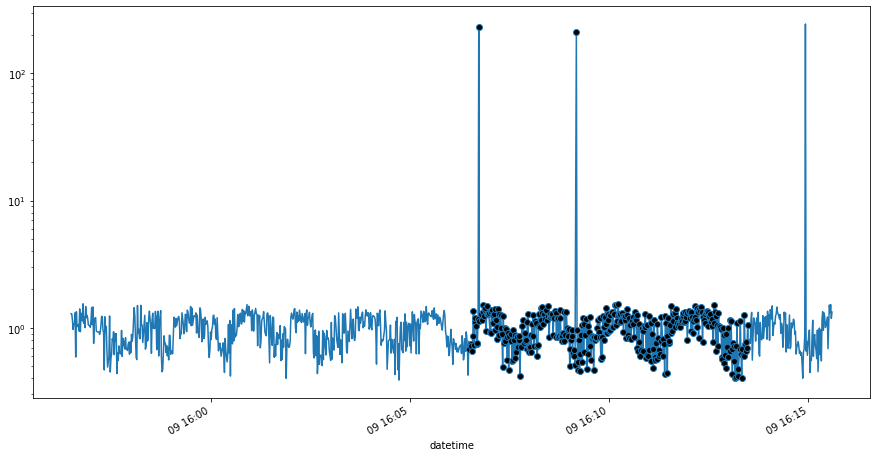

In [167]:
i = 0
curr_df = valve2_data[i][:min_length]
anomalies_marker = [curr_df.index.get_loc(date) for date in curr_df.query('anomaly == 1').index]
curr_df.Current.plot(
    markevery=anomalies_marker, 
    marker='o',
    markerfacecolor='black',
    logy=True
)
plt.show()

In [159]:
class ConvNet(nn.Module):
    def __init__(self) -> None:
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(8, 16, 100)  # L_out = 1075 + 2 * 1 - 1 * (100 - 1) = 978
        self.pool1 = nn.MaxPool1d(3)  # L_out = 978 + 2 - 99 = 881
        self.conv2 = nn.Conv1d(16, 32, 100)  # L_out = 881  + 2 - 99 = 784
        self.pool2 = nn.MaxPool1d(3)  # L_out = 784 + 3 - 100 = 687
        self.fc1 = nn.Linear(32 * 75, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        print("Conv1 shape output", out.shape)
        out = self.pool1(out)
        print('Pool1 shape output:', out.shape)
        
        out = self.conv2(out)
        out = F.relu(out)
        print("Conv2 shape output", out.shape)
        out = self.pool2(out)
        print('Pool2 shape output:', out.shape)

        out = out.view(-1, 32 * 75)

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))

        return out


In [150]:
valve1_dataset = {
    'train': [(
        torch.from_numpy(df[FEATURES].to_numpy()[:min_length].astype(np.float32).reshape(8, -1)).view(1, 8, -1),
        torch.from_numpy(df[TARGET].to_numpy()[:min_length].astype(np.float32)),
    ) for df in valve1_data[:12]],
    'val': [(
        torch.from_numpy(df[FEATURES].to_numpy()[:min_length].astype(np.float32).reshape(8, -1)).view(1, 8, -1),
        torch.from_numpy(df[TARGET].to_numpy()[:min_length].astype(np.float32)),
    ) for df in valve1_data[12:]],
}

In [161]:
torch.tensor(valve1_data[0][TARGET].to_numpy()[:min_length]).shape

torch.Size([1075, 1])

In [146]:
valve1_data[0][FEATURES].to_numpy()[:min_length].reshape(8, -1).shape

(8, 1075)

In [168]:
from torch.optim import lr_scheduler, Adam

model = ConvNet().to(device)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in valve1_dataset[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / len(valve1_dataset[phase])
        epoch_acc = running_corrects.double() / len(valve1_dataset[phase])

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

Epoch 0/9
----------
Conv1 shape output torch.Size([1, 16, 976])
Pool1 shape output: torch.Size([1, 16, 325])
Conv2 shape output torch.Size([1, 32, 226])
Pool2 shape output: torch.Size([1, 32, 75])


/home/neophyte/miniconda3/envs/ptVenv/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ValueError: Using a target size (torch.Size([1075, 1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.